# Power Systems SP 2025 - Group Project 3

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

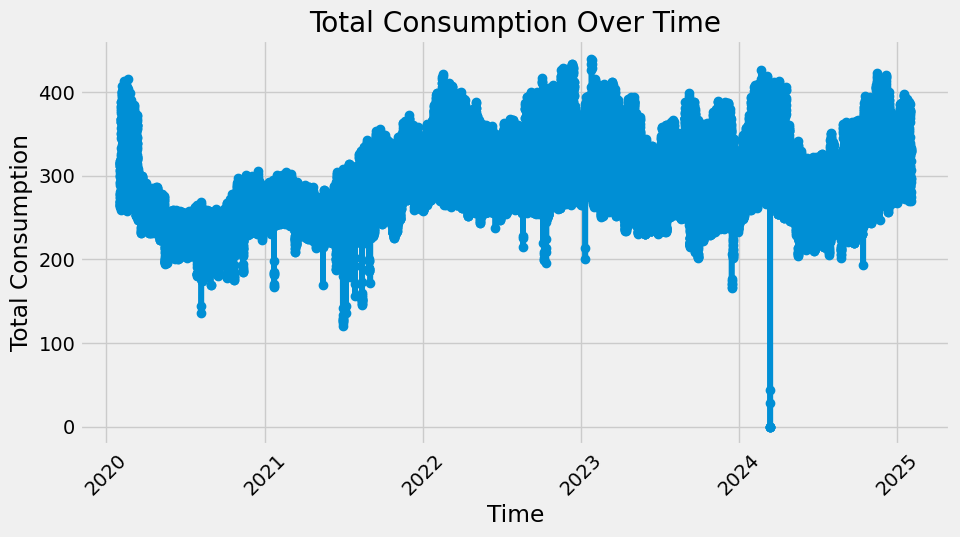

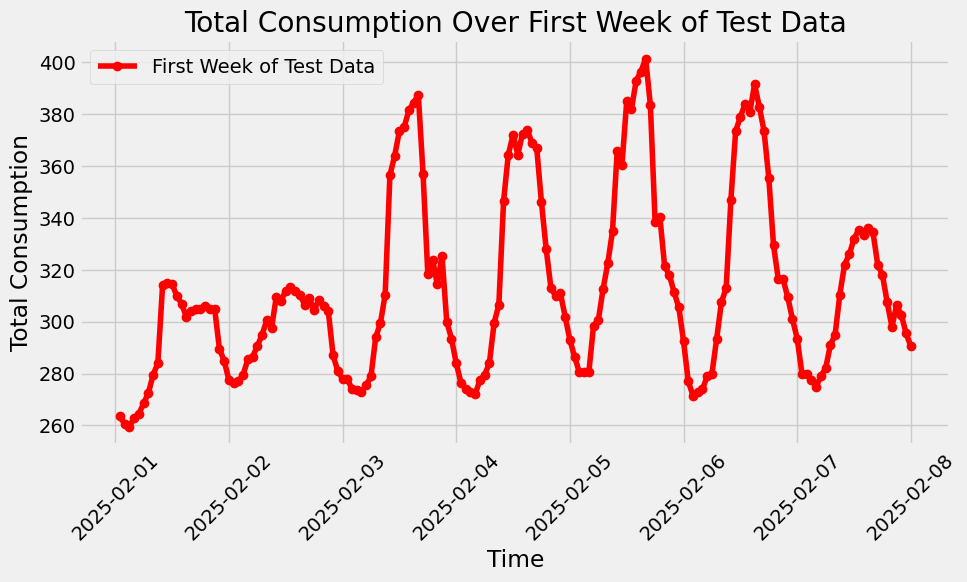

Expanded test data range: 2025-02-01 00:00:00 to 2025-02-28 23:00:00
         Interval End  Total Consumption
0 2025-02-01 00:00:00                NaN
1 2025-02-01 01:00:00              263.5
2 2025-02-01 02:00:00              260.5
3 2025-02-01 03:00:00              259.5
4 2025-02-01 04:00:00              263.0


In [6]:


# Load the data, skipping the first row and setting correct column names
data = pd.read_excel(
    "Model Development Data_Shepard 2025.xlsx",
    skiprows=1,  # Skip the first row (header)
    names=["Interval End", "Meter1", "Meter2"]  # Set custom column names
)

# Load the test data
test_data_init = pd.read_excel(
    "Evaluation Data Students_Shepard 2025.xlsx",
    skiprows=1,  # Skip the first row (header)
    names=["Interval End", "Meter1", "Meter2"]  # Set custom column names
)

# Convert 'Interval End' to datetime
data['Interval End'] = pd.to_datetime(data['Interval End'])
test_data_init['Interval End'] = pd.to_datetime(test_data_init['Interval End'])

# Add total consumption
data['Total Consumption'] = data['Meter1'] + data['Meter2']
data = data.drop(columns=['Meter1', 'Meter2'])  # Drop the original meter columns
test_data_init['Total Consumption'] = test_data_init['Meter1'] + test_data_init['Meter2']
test_data_init = test_data_init.drop(columns=['Meter1', 'Meter2'])  # Drop the original meter columns

# Determine time interval between measurements
test_data_init = test_data_init.sort_values(by="Interval End")  # Ensure sorted order
time_diff = test_data_init['Interval End'].diff().mode()[0]  # Most common time difference

# Generate full range of timestamps for the entire month of February 2025 (28 days)
full_time_range = pd.date_range(
    start="2025-02-01 00:00:00",  # Start of February 2025
    end="2025-02-28 23:59:59",  # End of February 2025
    freq=time_diff  # Ensure the same frequency as the original data
)

# Create a complete test DataFrame with all timestamps for February
test_data = pd.DataFrame({"Interval End": full_time_range})

# Merge the original test data with the complete time range to ensure no missing timestamps
test_data = pd.merge(test_data, test_data_init, on="Interval End", how="left")

# Plotting the training data
plt.figure(figsize=(10, 5))
plt.plot(data['Interval End'], data['Total Consumption'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Total Consumption')
plt.title('Total Consumption Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotting the first week of test data (February 1 to 7)
first_week_end = pd.Timestamp("2025-02-08 23:00")
first_week_data = test_data[(test_data['Interval End'] >= test_data['Interval End'].min()) & 
                             (test_data['Interval End'] <= first_week_end)]

plt.figure(figsize=(10, 5))
plt.plot(first_week_data['Interval End'], first_week_data['Total Consumption'], marker='o', linestyle='-', color='red', label="First Week of Test Data")
plt.xlabel('Time')
plt.ylabel('Total Consumption')
plt.title('Total Consumption Over First Week of Test Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Print expanded test data range and first few rows
print("Expanded test data range:", test_data['Interval End'].min(), "to", test_data['Interval End'].max())
print(test_data.head())




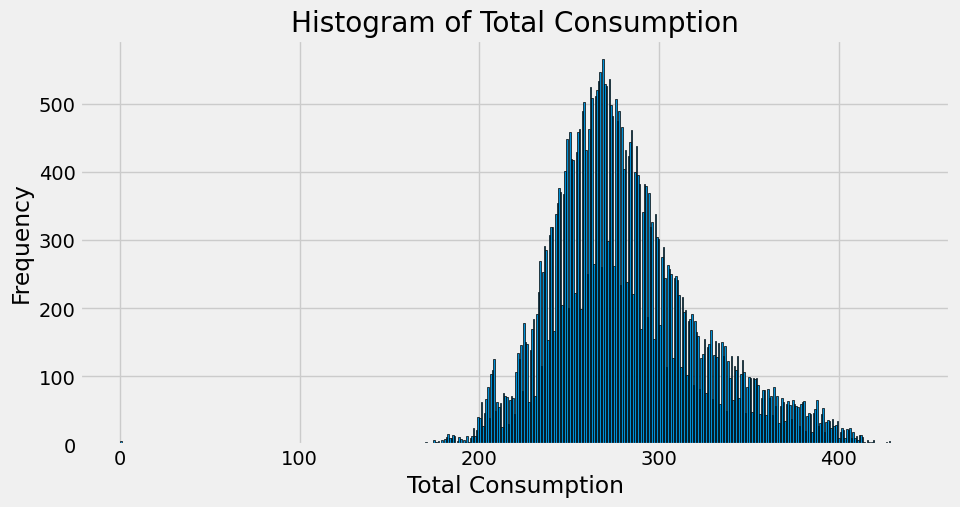

In [7]:
# Plot histogram of Total Consumption
plt.figure(figsize=(10, 5))
data['Total Consumption'].plot(kind='hist', bins=500, edgecolor='black')
plt.xlabel('Total Consumption')
plt.ylabel('Frequency')
plt.title('Histogram of Total Consumption')
plt.grid(True)
plt.show()


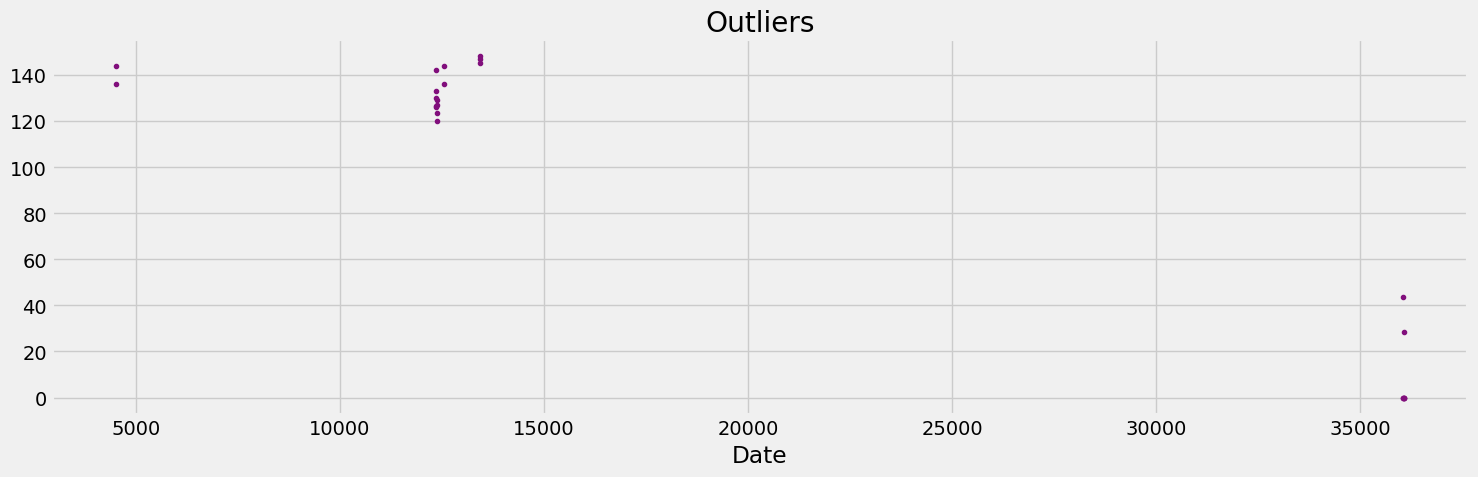

In [8]:


# Plot outliers with dates using the index
plt.figure(figsize=(15, 5))
data.query('`Total Consumption` < 150')['Total Consumption'].plot(
    style='.', 
    color=color_pal[5], 
    title='Outliers',
    xlabel='Date'  # 'Date' is the label for the x-axis
)
plt.tight_layout()
plt.show()






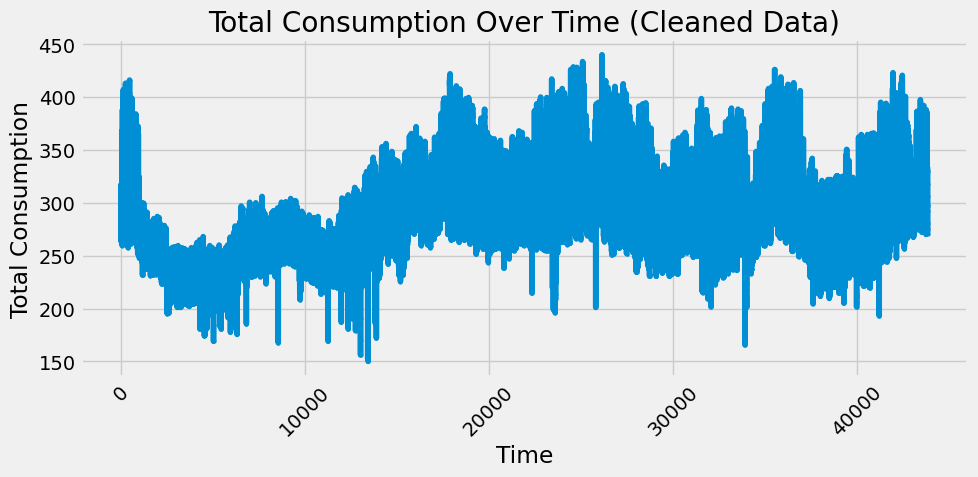

In [9]:
# Remove outliers (overwrite original 'data' variable)
data = data.query('`Total Consumption` >= 150')  # <-- Overwrite here

# Plot cleaned data (USE INDEX FOR DATETIME)
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Total Consumption'],  # <-- Key fix: use .index
         marker='o', linestyle='-', markersize=2)
plt.xlabel('Time')
plt.ylabel('Total Consumption')
plt.title('Total Consumption Over Time (Cleaned Data)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Feature extraction

# Read CCNY closed days from CSV
closed_days_df = pd.read_excel("CCNY CLOSED DAYS.xlsx")
closed_dates = pd.to_datetime(closed_days_df['Holidays'], format='%m/%d/%Y').dt.date
closed_dates_set = set(closed_dates)

# Function to determine peak period
def categorize_peak(hour, day_type):
    if day_type in [3, 4]:  # Weekends & Closed Days
        if 10 <= hour < 21:
            return 1  # Peak
        elif 0 <= hour < 8 or 22 <= hour < 24:
            return 0.1  # Off-Peak
        else:
            return 0.5  # Semi-Peak
    else:  # Weekdays & Fridays
        if 8 <= hour < 11 or 17 <= hour < 22:
            return 1.5  # Semi-Peak
        elif 11 <= hour < 17:
            return 2  # Peak
        else:
            return 0.1  # Off-Peak
        
# Function to assign DayType
def get_day_type(date):
    day_of_week = date.weekday()
    if date in closed_dates_set:
        return 4  # Closed day
    elif day_of_week == 4:  # Friday
        return 2
    elif day_of_week in [5, 6]:  # Weekend (Sat-Sun)
        return 3
    else:
        return 1  # Monday-Thursday
    

# Function to compute historical lag mean with removal of specific lags
def compute_historical_lag_mean(df):
    lag_intervals = [8736 * i for i in range(1, 6)]  # Lags at 1-year intervals for 5 years
    for i, lag in enumerate(lag_intervals):
        df[f'lag_{lag}'] = df['Total Consumption'].shift(lag)

    # Fill missing values according to the rule:
    for i, lag in enumerate(lag_intervals):
        if i == 0:  # First year (8736h ago)
            df[f'lag_{lag}'] = df['Total Consumption']  # Avoid inplace
        else:  # Other years
            df[f'lag_{lag}'] = df[f'lag_{lag_intervals[i-1]}']  # Avoid inplace

    # Compute historical average lag
    df['Historical_Avg_Lag'] = df[[f'lag_{lag}' for lag in lag_intervals]].mean(axis=1)

    # Drop the individual lag columns
    df.drop(columns=[f'lag_{lag}' for lag in lag_intervals], inplace=True)

    return df

# Function to process dataset (applies transformations to both `data` and `test_data`)
def process_data(df, is_train=True):
    df['Month'] = df['Interval End'].dt.month
    df['DayType'] = df['Interval End'].dt.date.apply(get_day_type)
    df['Hour'] = df['Interval End'].dt.hour
    df['Peak'] = df.apply(lambda row: categorize_peak(row['Hour'], row['DayType']), axis=1)

    # Add Pandemic indicator
    pandemic_start = pd.to_datetime('2020-03-19')
    pandemic_end = pd.to_datetime('2021-08-28')
    df['Pandemic'] = ((df['Interval End'] >= pandemic_start) & (df['Interval End'] <= pandemic_end)).astype(int)

    # Extract week number in the year
    df['WeekOfYear'] = df['Interval End'].dt.isocalendar().week

    return df

# Apply processing functions
data = process_data(data, is_train=True)  # Training data
data = compute_historical_lag_mean(data)  # Add historical lag to training data

test_data = process_data(test_data, is_train=False)  # Test data

# Map Historical_Avg_Lag from training set to test set
historical_lag_map = data.groupby(['Month', 'DayType', 'Hour'])['Historical_Avg_Lag'].mean()
test_data['Historical_Avg_Lag'] = test_data.apply(lambda row: historical_lag_map.get((row['Month'], row['DayType'], row['Hour']), None), axis=1)

# Resample test data to 28 * 24 shape
test_data['Date'] = test_data['Interval End'].dt.date
test_data['Hour'] = test_data['Interval End'].dt.hour

# Ensure unique rows per Hour per Date (28 * 24 structure)
test_data = test_data.drop_duplicates(subset=['Date', 'Hour'])
test_data.drop(columns=['Date'], inplace=True)

# Create interaction column: Peak * Hour
data['Peak_Hour_Interaction'] = data['Peak'] * data['Hour']
test_data['Peak_Hour_Interaction'] = test_data['Peak'] * test_data['Hour']

# Add day of the week (0=Monday to 6=Sunday)
data['Day'] = data['Interval End'].dt.weekday
test_data['Day'] = test_data['Interval End'].dt.weekday

# Create interaction column: Peak * Hour * Day
data['Peak_Hour_Day_Interaction'] = data['Peak'] * data['Hour'] * data['Day']
test_data['Peak_Hour_Day_Interaction'] = test_data['Peak'] * test_data['Hour'] * test_data['Day']

data['Day_Hour_Interaction'] = data['Day'] * data['Hour']
test_data['Day_Hour_Interaction'] = test_data['Day'] * test_data['Hour']

data.drop(columns=['Peak'], inplace=True)
test_data.drop(columns=['Peak'], inplace=True)

# Check shape and output
print("Processed Data Columns:", data.columns)
print(data.head())
print(data.shape)

print("Processed Test Data Columns:", test_data.columns)
print(test_data.head())
print(test_data.shape)

Processed Data Columns: Index(['Interval End', 'Total Consumption', 'Month', 'DayType', 'Hour',
       'Pandemic', 'WeekOfYear', 'Historical_Avg_Lag', 'Peak_Hour_Interaction',
       'Day', 'Peak_Hour_Day_Interaction', 'Day_Hour_Interaction'],
      dtype='object')
         Interval End  Total Consumption  Month  DayType  Hour  Pandemic  \
0 2020-02-01 01:00:00              269.0      2        3     1         0   
1 2020-02-01 02:00:00              269.5      2        3     2         0   
2 2020-02-01 03:00:00              268.5      2        3     3         0   
3 2020-02-01 04:00:00              269.5      2        3     4         0   
4 2020-02-01 05:00:00              267.5      2        3     5         0   

   WeekOfYear  Historical_Avg_Lag  Peak_Hour_Interaction  Day  \
0           5               269.0                    0.1    5   
1           5               269.5                    0.2    5   
2           5               268.5                    0.3    5   
3           5    

In [11]:
# Load the natural gas prices
gas_data = pd.read_csv("Natural Gas (Henry Hub).csv")
gas_data['Date'] = pd.to_datetime(gas_data['Date'], format='%m/%d/%y').dt.date

# Filter gas data for the required date ranges
train_gas_data = gas_data[gas_data['Date'] <= pd.to_datetime('01/31/2025').date()]
test_gas_data = gas_data[(gas_data['Date'] >= pd.to_datetime('02/01/2025').date()) & 
                          (gas_data['Date'] <= pd.to_datetime('02/28/2025').date())]

# Merge natural gas prices with our training and test data
# Ensure 'Interval End' in our data is in the correct datetime format
data['Date'] = data['Interval End'].dt.date
test_data['Date'] = test_data['Interval End'].dt.date

# Merge on 'Date', filling missing values forward for each day's price
train_data = pd.merge(data, train_gas_data[['Date', 'Close']], how='left', on='Date')
test_data = pd.merge(test_data, test_gas_data[['Date', 'Close']], how='left', on='Date')

# Clean up the data by dropping temporary columns
train_data = train_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

# Forward-fill and backward-fill missing gas price values
train_data['Close'] = train_data['Close'].ffill()
train_data['Close'] = train_data['Close'].bfill()

test_data['Close'] = test_data['Close'].ffill()
test_data['Close'] = test_data['Close'].bfill()





In [12]:
# ----- TRAINING DATA (Daily) -----
# 1. Load and combine weather data (training)
weather1 = pd.read_csv("Weather data 2020-02-01 to 2022-10-01.csv")
weather2 = pd.read_csv("Weather data 2022-10-02 to 2025-01-31.csv")
weather = pd.concat([weather1, weather2], axis=0)

# 2. Verify columns exist before selection
required_columns = ['datetime', 'temp', 'humidity', 'solarradiation']
assert all(col in weather.columns for col in required_columns), "Missing columns in weather data"

# 3. Process weather data (training) - DAILY MERGE
weather = weather[required_columns].copy()
weather['Date'] = pd.to_datetime(weather['datetime'], errors='coerce').dt.date
weather = weather.drop(columns=['datetime'])
weather = weather.groupby('Date').first().reset_index()  # Ensure one row per date

# 4. Prepare training energy data (daily data)
train_data['Date'] = train_data['Interval End'].dt.date

# 5. Merge weather data with training data (DAILY-MERGE)
train_data = pd.merge(
    train_data,
    weather,
    on='Date',
    how='left'
)

# 6. Forward-fill weather columns
weather_cols = ['temp', 'humidity', 'solarradiation']
train_data[weather_cols] = train_data[weather_cols].ffill()

# # Create lag for temp in training data
# train_data['temp_lag24'] = train_data['temp'].shift(24)
# train_data.loc[:23, 'temp_lag24'] = train_data.loc[:23, 'temp']

# 7. Cleanup training data
train_data = train_data.drop(columns=['Date'])

# ----- TEST DATA (Hourly) -----
# 1. Load and process HOURLY weather data
weather_test = pd.read_csv("Weather_Test_correct.csv")
weather_test = weather_test[required_columns].copy()
weather_test['Interval End'] = pd.to_datetime(weather_test['datetime'], errors='coerce')
weather_test = weather_test.drop(columns=['datetime'])

# 2. Merge on EXACT HOURLY TIMESTAMPS
test_data = pd.merge(
    test_data,
    weather_test,
    on='Interval End',  # Match exact hourly timestamps
    how='left'
)

# 3. Forward-fill any missing weather data
test_data[weather_cols] = test_data[weather_cols].ffill()

# # 4. Create lag for temp in test data
# test_data['temp_lag24'] = test_data['temp'].shift(24)
# test_data.loc[:23, 'temp_lag24'] = test_data.loc[:23, 'temp']  # Fix typo: test_data instead of train_data

In [13]:
# Check NA counts and print results
na_counts_train = train_data.isna().sum()
na_counts_test = test_data.isna().sum()

# Print missing values report for training data
print("\nTRAINING DATA MISSING VALUES REPORT:")
print("-------------------------------------")
for col, count in na_counts_train.items():
    percentage = (count / len(train_data)) * 100
    if count > 0:
        print(f"{col}: {count} missing ({percentage:.2f}%)")
    else:
        print(f"{col}: No missing values")

# Print missing values report for test data
print("\nTEST DATA MISSING VALUES REPORT:")
print("----------------------------------")
for col, count in na_counts_test.items():
    percentage = (count / len(test_data)) * 100
    if count > 0:
        print(f"{col}: {count} missing ({percentage:.2f}%)")
    else:
        print(f"{col}: No missing values")

# Check total rows in datasets
print("-----------------------")
print(f"Total rows in training data: {len(train_data)}")
print(f"Total rows in test data: {len(test_data)}")


TRAINING DATA MISSING VALUES REPORT:
-------------------------------------
Interval End: No missing values
Total Consumption: No missing values
Month: No missing values
DayType: No missing values
Hour: No missing values
Pandemic: No missing values
WeekOfYear: No missing values
Historical_Avg_Lag: No missing values
Peak_Hour_Interaction: No missing values
Day: No missing values
Peak_Hour_Day_Interaction: No missing values
Day_Hour_Interaction: No missing values
Close: No missing values
temp: No missing values
humidity: No missing values
solarradiation: No missing values

TEST DATA MISSING VALUES REPORT:
----------------------------------
Interval End: No missing values
Total Consumption: 504 missing (75.00%)
Month: No missing values
DayType: No missing values
Hour: No missing values
Pandemic: No missing values
WeekOfYear: No missing values
Historical_Avg_Lag: No missing values
Peak_Hour_Interaction: No missing values
Day: No missing values
Peak_Hour_Day_Interaction: No missing values
D

In [14]:
print(train_data.head())
print(train_data.shape)

print(test_data.head())
print(test_data.tail())
print(test_data.shape)
print(test_data.columns)

         Interval End  Total Consumption  Month  DayType  Hour  Pandemic  \
0 2020-02-01 01:00:00              269.0      2        3     1         0   
1 2020-02-01 02:00:00              269.5      2        3     2         0   
2 2020-02-01 03:00:00              268.5      2        3     3         0   
3 2020-02-01 04:00:00              269.5      2        3     4         0   
4 2020-02-01 05:00:00              267.5      2        3     5         0   

   WeekOfYear  Historical_Avg_Lag  Peak_Hour_Interaction  Day  \
0           5               269.0                    0.1    5   
1           5               269.5                    0.2    5   
2           5               268.5                    0.3    5   
3           5               269.5                    0.4    5   
4           5               267.5                    0.5    5   

   Peak_Hour_Day_Interaction  Day_Hour_Interaction  Close  temp  humidity  \
0                        0.5                     5  1.819  42.1      89.0  

(672, 17)
(43825, 17)
Train Data Range: 2020-02-01 01:00:00 to 2025-01-22 23:00:00
Test Data Range: 2025-01-23 00:00:00 to 2025-02-28 23:00:00


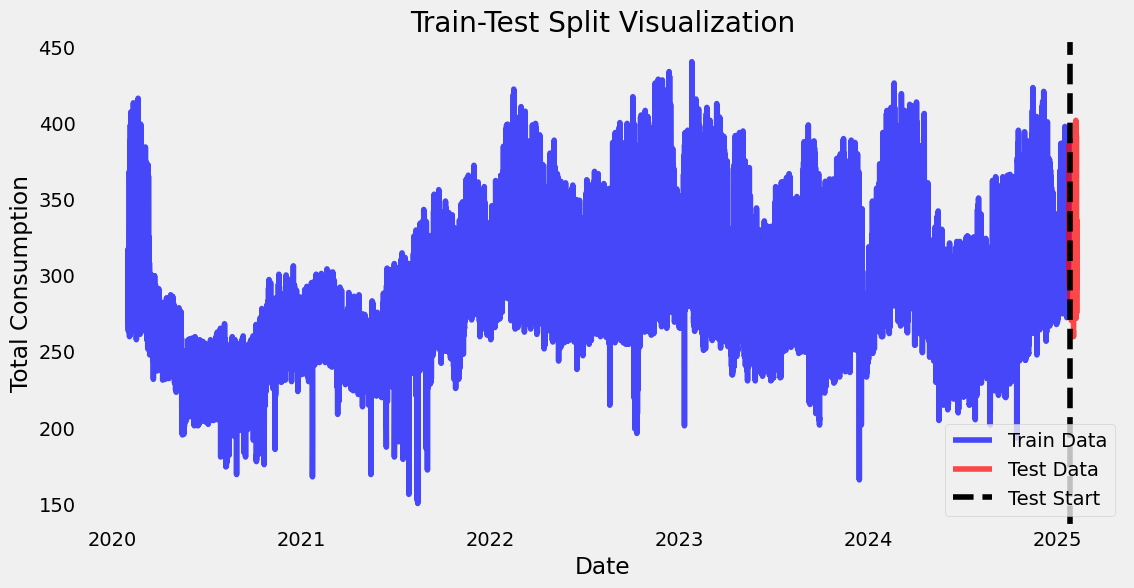

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set datetime index for both train and test datasets
train_data = train_data.set_index('Interval End').sort_index()
test_data = test_data.set_index('Interval End').sort_index()

# Hourly cyclical features
# Transform the hour of the day (0-23) into cyclical features using sine and cosine.
# This ensures that the model understands that hour 23 is close to hour 0.
train_data['hour_sin'] = np.sin(2 * np.pi * train_data.index.hour / 24)  # Sine transformation for hour
train_data['hour_cos'] = np.cos(2 * np.pi * train_data.index.hour / 24)  # Cosine transformation for hour
test_data['hour_sin'] = np.sin(2 * np.pi * test_data.index.hour / 24)    # Same transformation for test data
test_data['hour_cos'] = np.cos(2 * np.pi * test_data.index.hour / 24)    # Same transformation for test data

# # Weekly cyclical features
# # Transform the week of the year (1-52) into cyclical features using sine and cosine.
# # This ensures that the model understands that week 52 is close to week 1.
# train_data['week_sin'] = np.sin(2 * np.pi * (train_data.index.isocalendar().week.astype(int)) / 52)  # Sine transformation for week
# train_data['week_cos'] = np.cos(2 * np.pi * (train_data.index.isocalendar().week.astype(int)) / 52)  # Cosine transformation for week
# test_data['week_sin'] = np.sin(2 * np.pi * (test_data.index.isocalendar().week.astype(int)) / 52)    # Same transformation for test data
# test_data['week_cos'] = np.cos(2 * np.pi * (test_data.index.isocalendar().week.astype(int)) / 52)    # Same transformation for test data
print(test_data.shape)
print(train_data.shape)

# Merge train and test sets
full_data = pd.concat([train_data, test_data])

# Ensure data is sorted properly
full_data = full_data.sort_index()

# Define split dates
test_start = pd.Timestamp('2025-01-23 00:00:00')
test_end = pd.Timestamp('2025-02-28 23:00:00')

# Re-split the data
train_data = full_data[full_data.index < test_start]
test_data = full_data[(full_data.index >= test_start) & (full_data.index <= test_end)]

# Define X (features) and y (target)
X_train = train_data.drop(columns=['Total Consumption'])
y_train = train_data['Total Consumption']

X_test = test_data.drop(columns=['Total Consumption'])
y_test = test_data['Total Consumption']

# Confirm split results
print(f"Train Data Range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test Data Range: {test_data.index.min()} to {test_data.index.max()}")

# Plot train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, y_train, label='Train Data', color='blue', alpha=0.7)
plt.plot(test_data.index, y_test, label='Test Data', color='red', alpha=0.7)

# Mark the split date
plt.axvline(pd.Timestamp('2025-01-25 00:00:00'), color='black', linestyle='--', label='Test Start')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.grid()

# Show plot
plt.show()

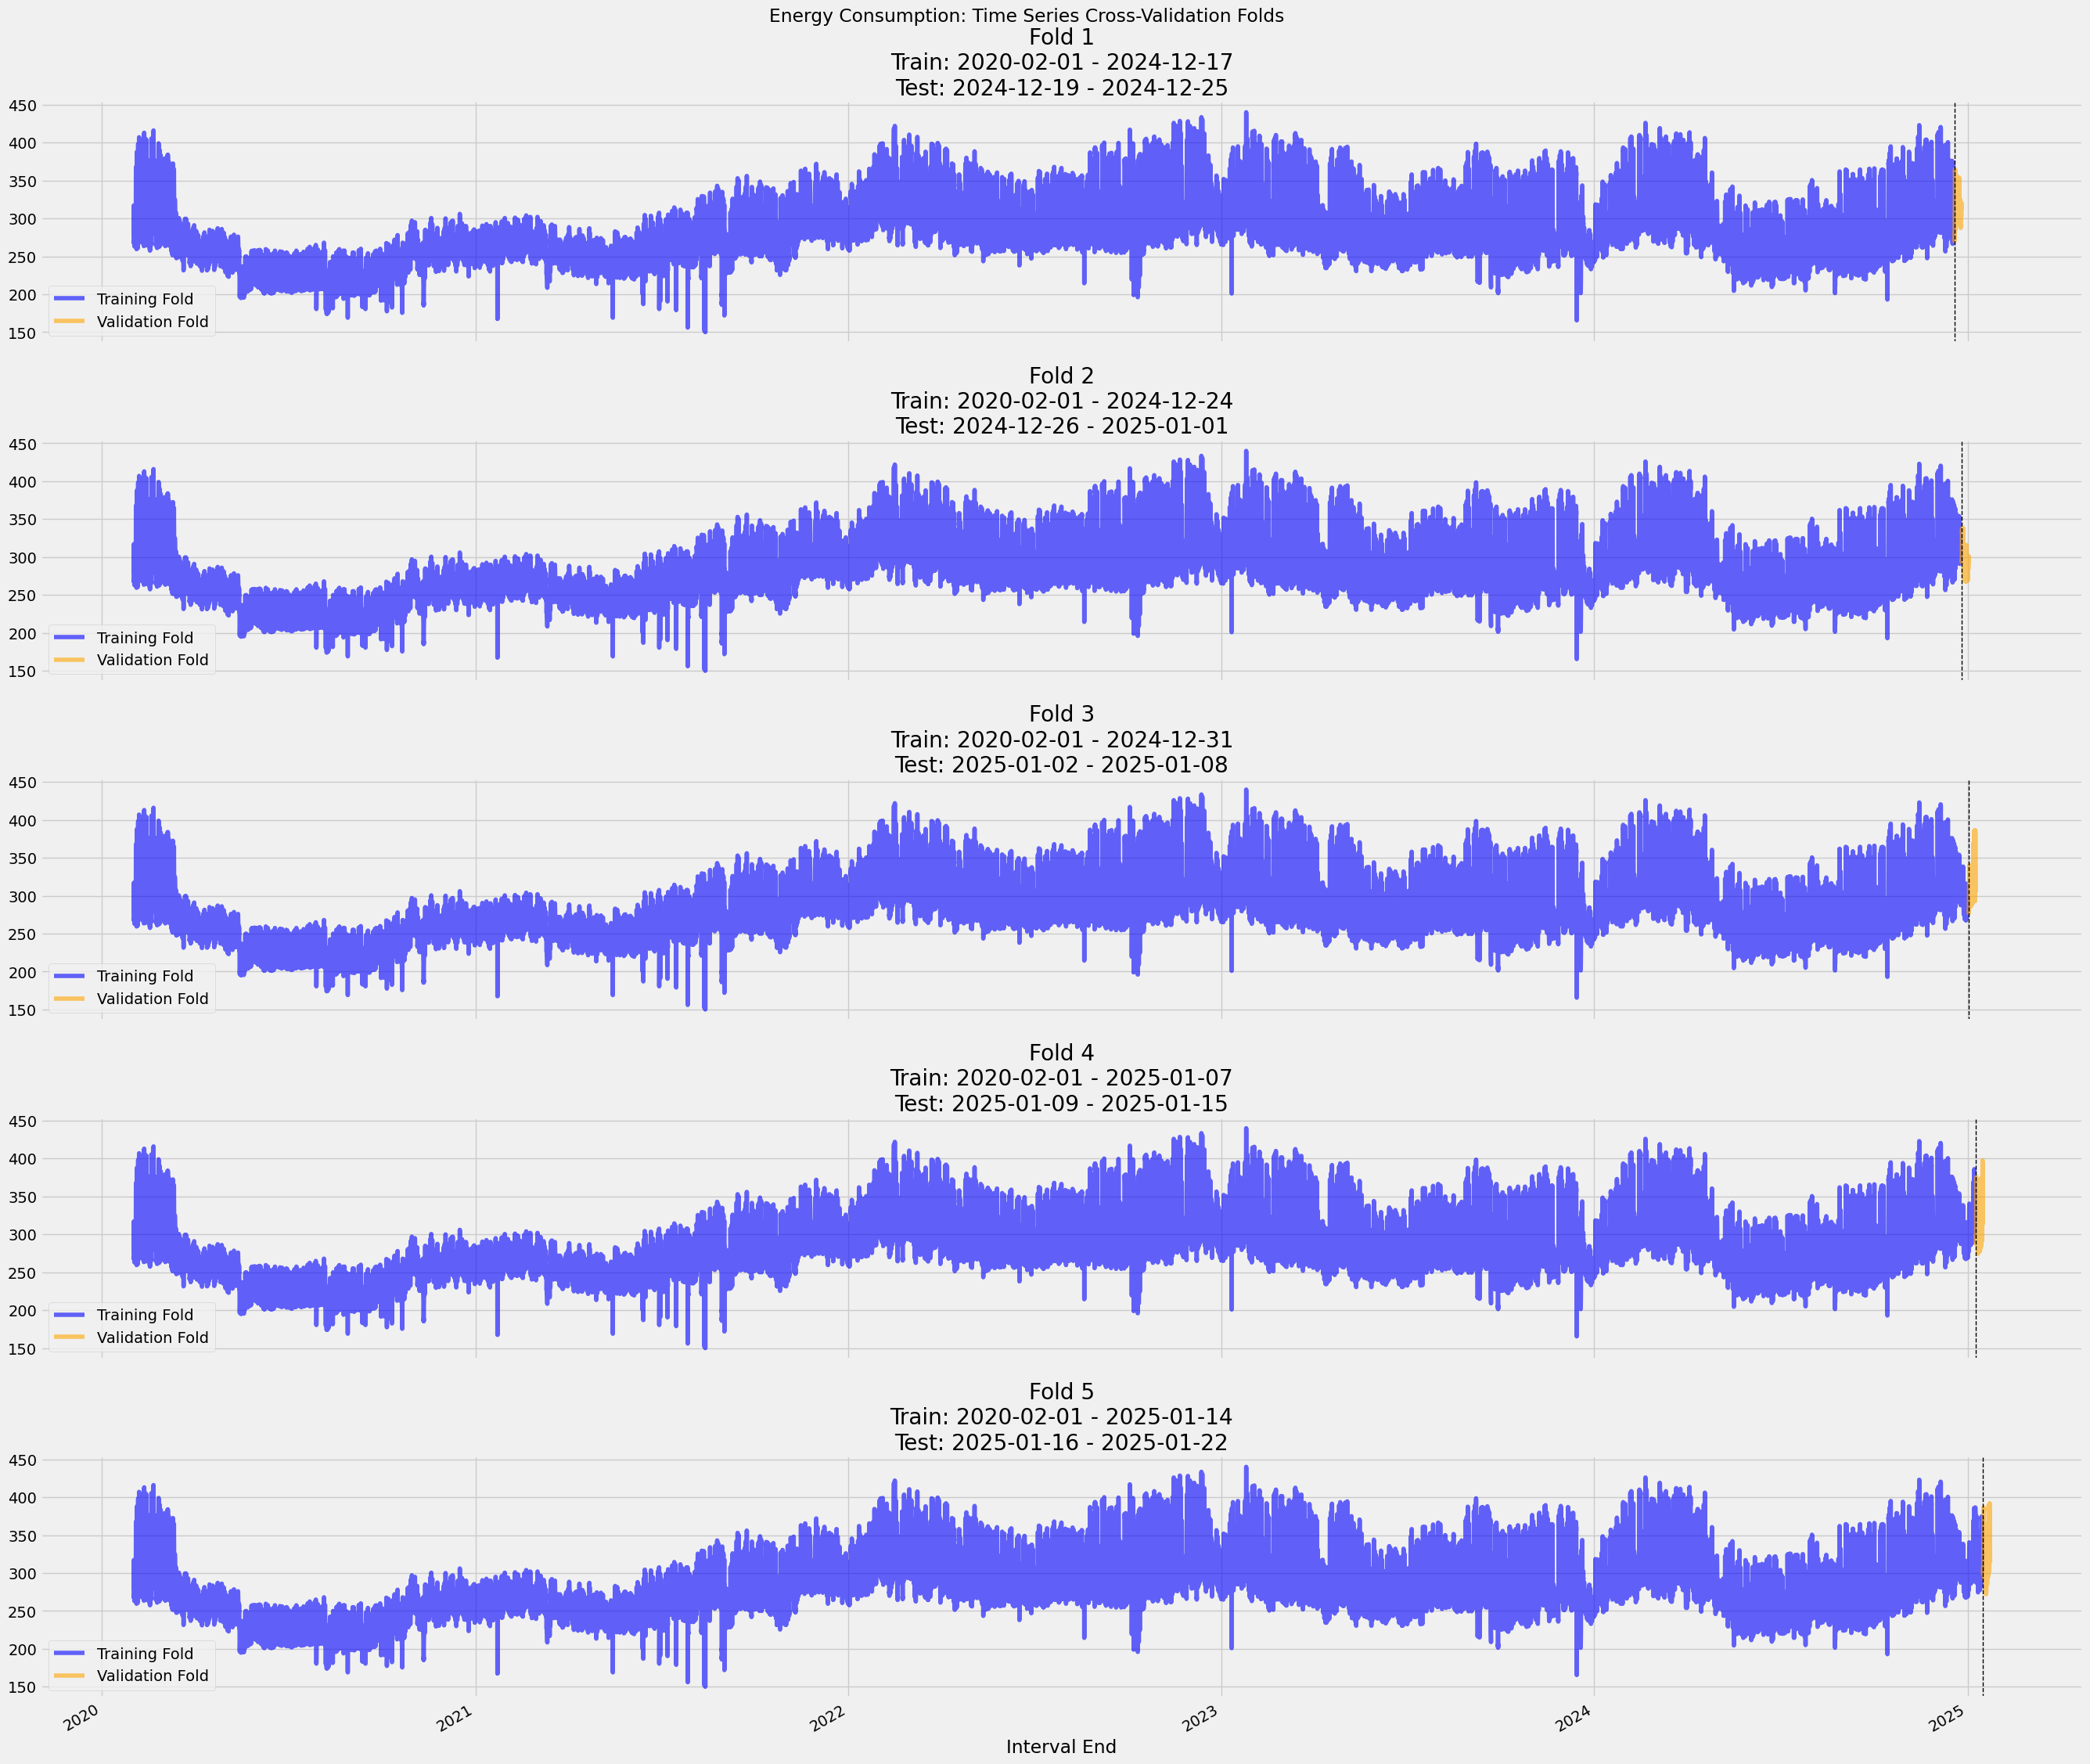

In [16]:
from sklearn.model_selection import TimeSeriesSplit


# Set up time series cross-validation
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)

# Create plot grid with shared x-axis
fig, axs = plt.subplots(5, 1, figsize=(30, 30), sharex=True)
plt.subplots_adjust(hspace=0.4)

# Convert index to datetime if not already
train_data.index = pd.to_datetime(train_data.index)

# Plot each fold using your data columns
fold = 0
for train_idx, val_idx in tss.split(train_data):
    train_fold = train_data.iloc[train_idx]
    test_fold = train_data.iloc[val_idx]
    
    # Plot training fold data
    train_fold['Total Consumption'].plot(
        ax=axs[fold],
        label='Training Fold',
        color='blue',
        alpha=0.6
    )
    
    # Plot validation fold data
    test_fold['Total Consumption'].plot(
        ax=axs[fold],
        label='Validation Fold',
        color='orange',
        alpha=0.6
    )
    
    # Add separation line and annotations
    axs[fold].axvline(test_fold.index.min(), 
                     color='black', 
                     linestyle='--',
                     linewidth=1)
    
    axs[fold].set_title(
        f'Fold {fold+1}\n'
        f'Train: {train_fold.index.date.min()} - {train_fold.index.date.max()}\n'
        f'Test: {test_fold.index.date.min()} - {test_fold.index.date.max()}'
    )
    
    axs[fold].legend()
    fold += 1

# Add main title and format dates
plt.suptitle('Energy Consumption: Time Series Cross-Validation Folds', y=0.92)
fig.autofmt_xdate()
plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd


#  Hyperparameter Tuning on Optimal Features
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=tss,  # Match original setup
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)  




RandomizedSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=168),
                   estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, scoring='neg_mean_squared_error')

In [18]:
# Final Evaluation

best_model = search.best_estimator_

# Predict entire test set first (optional)
y_pred = best_model.predict(X_test)

# Get subset using index
start_date = pd.Timestamp('2025-02-01 01:00')
end_date = pd.Timestamp('2025-02-07 23:00')
test_data_subset = test_data.loc[start_date:end_date]

# Prepare features
X_test_subset = test_data_subset.drop(columns=['Total Consumption'])
y_test_subset = test_data_subset['Total Consumption']

# Predict and evaluate
y_pred_subset = best_model.predict(X_test_subset)

mae = mean_absolute_error(y_test_subset, y_pred_subset)
mape = mean_absolute_percentage_error(y_test_subset, y_pred_subset)
mse = mean_squared_error(y_test_subset, y_pred_subset)

print(f"Best Parameters: {search.best_params_}")
print(f"MAE (Feb 1-7 2025): {mae:.2f}")
print(f"MSE (Feb 1-7 2025): {mse:.2f}")

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
MAE (Feb 1-7 2025): 8.25
MSE (Feb 1-7 2025): 110.85


Historical_Avg_Lag           0.564519
Pandemic                     0.111213
Close                        0.085598
Hour                         0.040687
Day_Hour_Interaction         0.036868
hour_sin                     0.034689
hour_cos                     0.022316
WeekOfYear                   0.020607
humidity                     0.020140
Month                        0.014736
DayType                      0.010783
Peak_Hour_Day_Interaction    0.009800
temp                         0.008245
Day                          0.007522
solarradiation               0.007356
Peak_Hour_Interaction        0.004920
dtype: float64


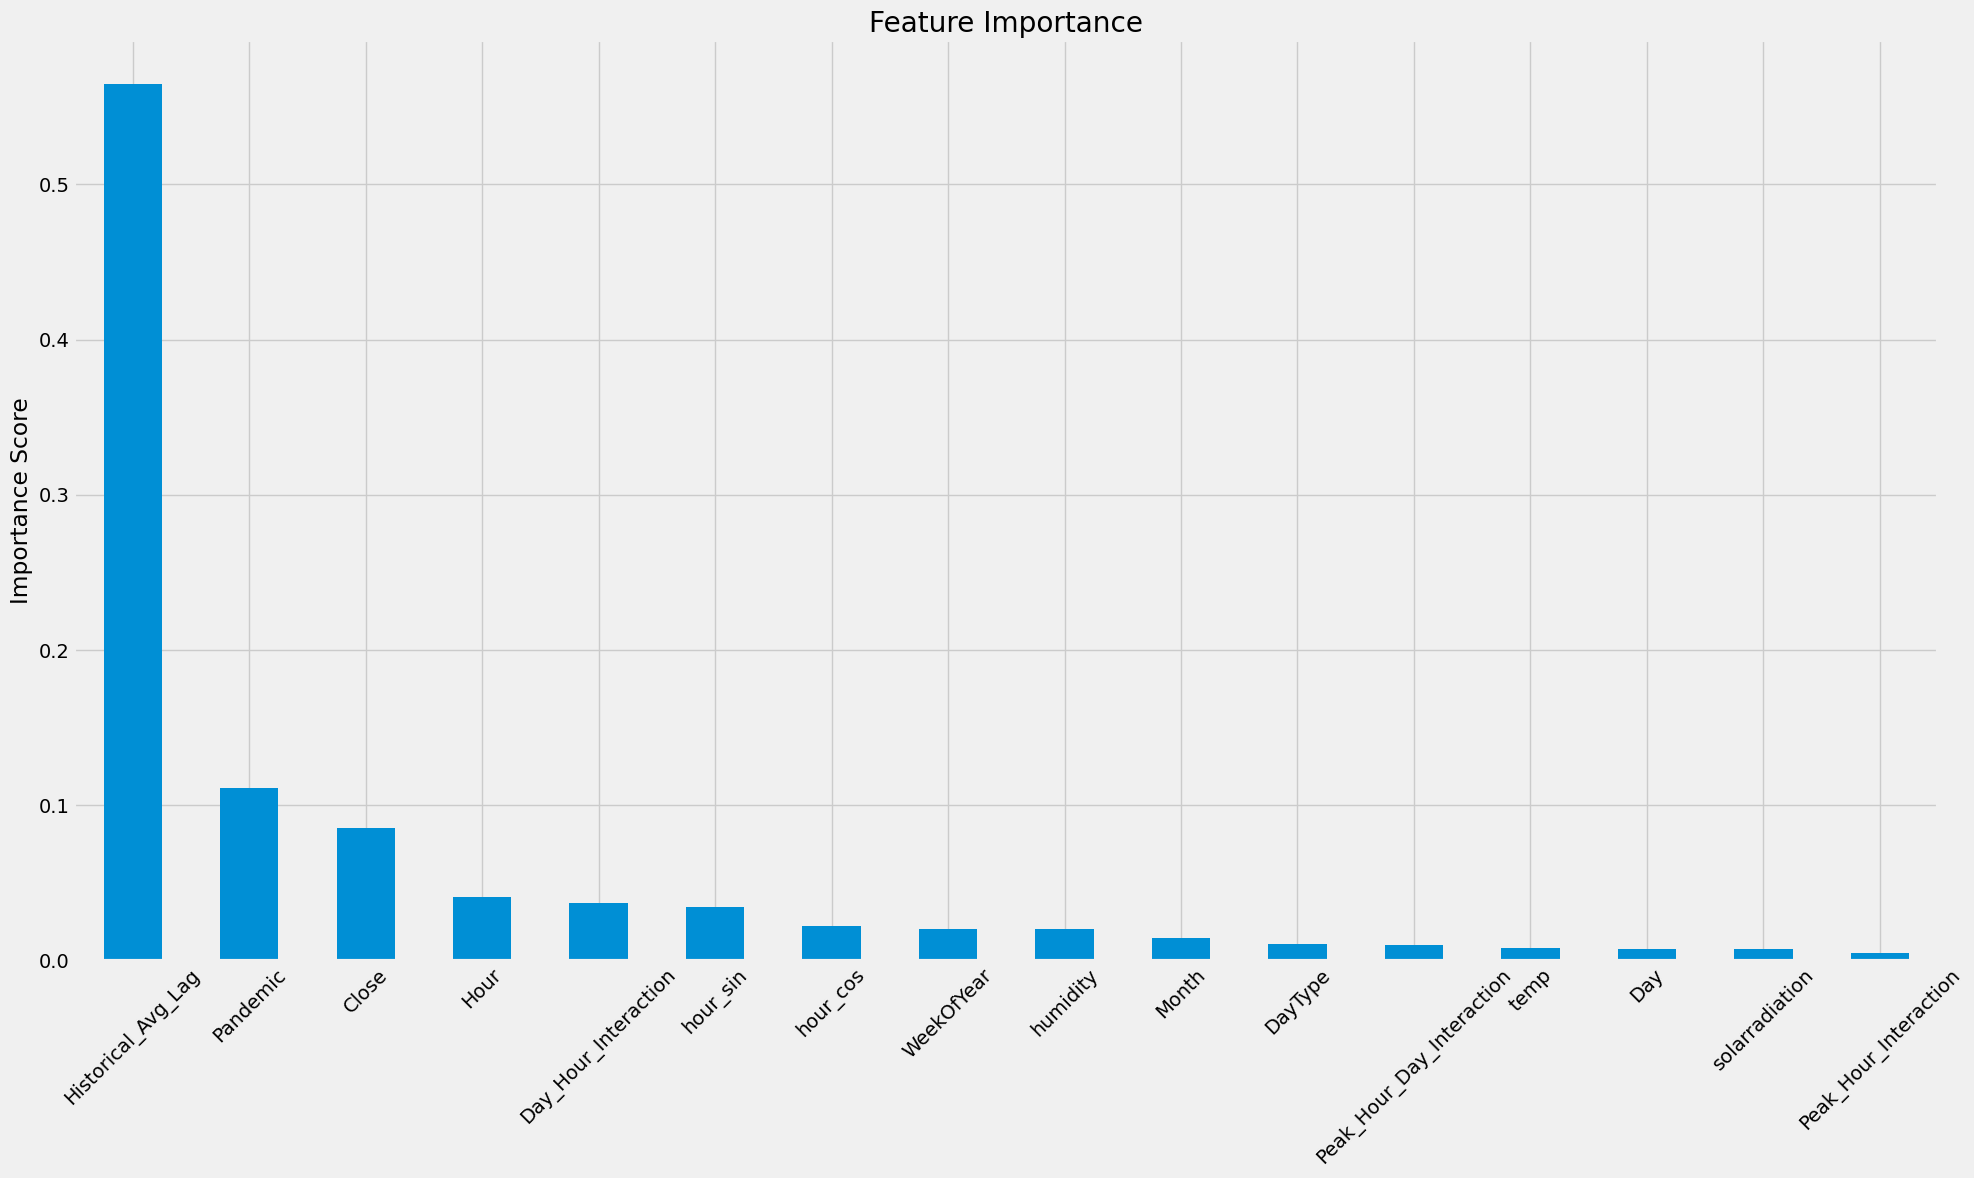

In [19]:

# Get feature importance
features = [
    'Month', 'DayType', 'Hour', 'Pandemic', 'WeekOfYear', 
    'Historical_Avg_Lag', 'Close', 'temp', 'humidity', 'solarradiation', 
     'hour_sin', 'hour_cos','Peak_Hour_Interaction', 'Day', 'Peak_Hour_Day_Interaction'
     , 'Day_Hour_Interaction'
]

importances = best_model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print(feature_importance)

# Plot
plt.figure(figsize=(20, 12))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


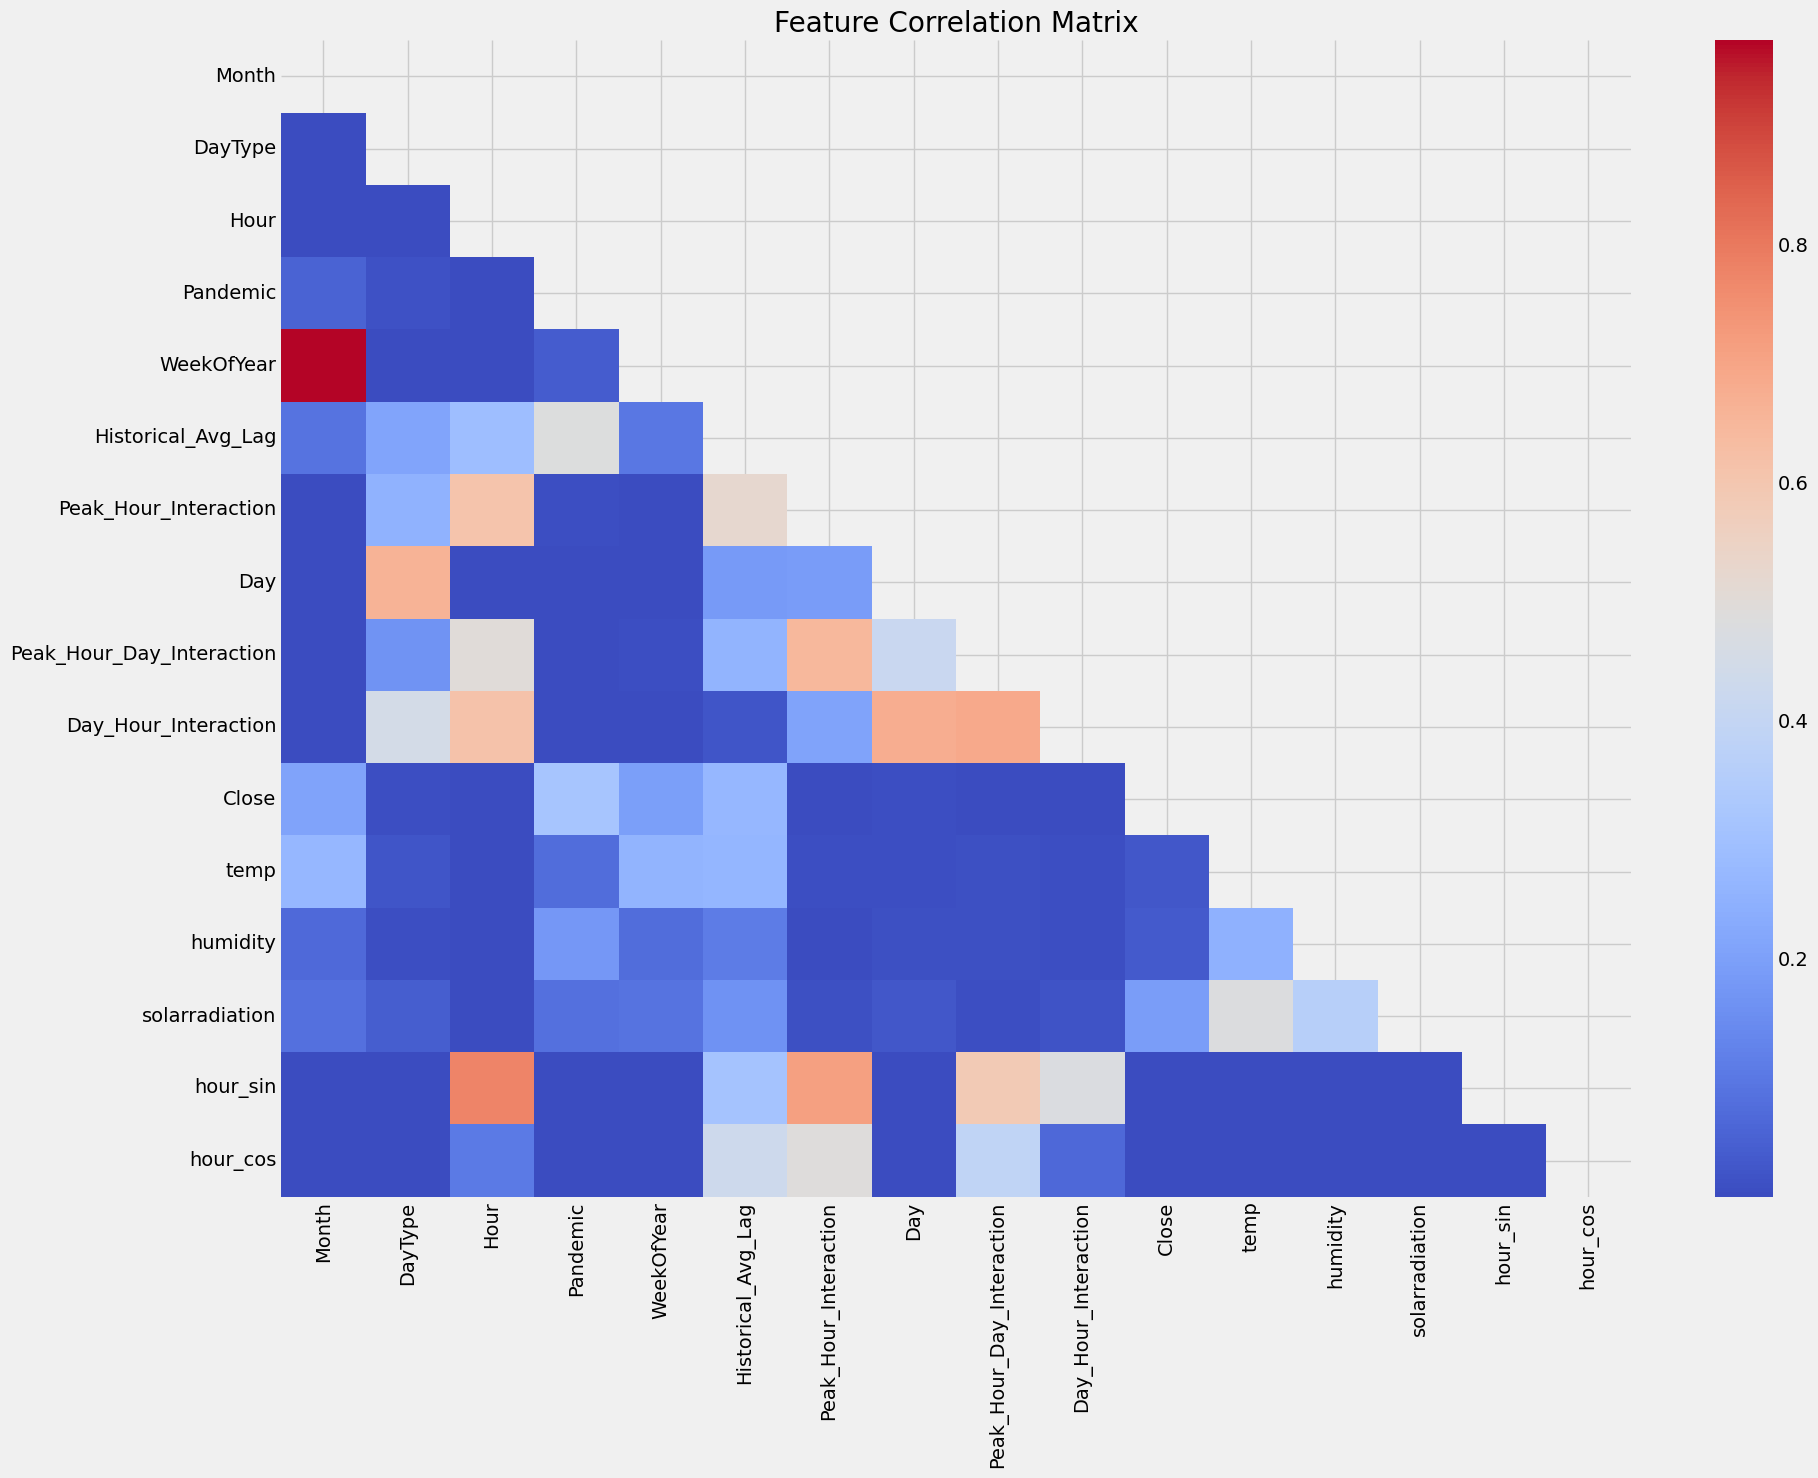

Highly Correlated Features (r > 0.90):
WeekOfYear & Month - Correlation: 0.97


In [20]:
# Calculate correlation matrix
corr_matrix = X_train.corr().abs()

# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify high-correlation pairs (>0.95)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.95:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

# Print high-correlation features
print("Highly Correlated Features (r > 0.90):")
for pair in high_corr:
    print(f"{pair[0]} & {pair[1]} - Correlation: {pair[2]:.2f}")

In [21]:
# # ---Feature Selection Logic ---
# # Create feature removal list
# features_to_remove = []

# # 1. Handle correlated features (keep more important one)
# print("\nProcessing correlated features:")
# for pair in high_corr:
#     feat1, feat2, corr = pair
#     # Get importance scores
#     imp1 = feature_importance.get(feat1, 0)
#     imp2 = feature_importance.get(feat2, 0)
    
#     # Determine which to remove
#     if imp1 > imp2:
#         remove = feat2
#         keep = feat1
#     else:
#         remove = feat1
#         keep = feat2
        
#     print(f"Between {feat1} ({imp1:.4f}) and {feat2} ({imp2:.4f}): "
#           f"Keeping {keep}, removing {remove}")
#     features_to_remove.append(remove)

# # 2. Remove low-importance features (<1% importance)
# importance_threshold = 0.01  # 1% threshold
# low_importance = feature_importance[feature_importance < importance_threshold].index.tolist()
# print("\nLow importance features to remove:")
# print(low_importance)
# features_to_remove.extend(low_importance)

# # Remove duplicates and preserve order
# features_to_remove = list(dict.fromkeys(features_to_remove))

# # --- Step 4: Create Optimized Feature Set ---
# optimized_features = [f for f in features if f not in features_to_remove]

# print("\nFeature Selection Results:")
# print(f"Original feature count: {len(features)}")
# print(f"Removed features ({len(features_to_remove)}): {features_to_remove}")
# print(f"New feature count: {len(optimized_features)}")
# print("Optimized features:", optimized_features)

In [22]:
# X_train_opt = X_train[optimized_features]
# X_test_opt = X_test[optimized_features]


# search.fit(X_train_opt, y_train)

# # Final Evaluation
# best_model = search.best_estimator_

# # Prepare test subset using proper index-based selection
# date_range = (X_test_opt.index >= '2025-02-01 01:00') & (X_test_opt.index <= '2025-02-07 23:00')
# X_test_subset = X_test_opt[date_range]
# y_test_subset = y_test[date_range]

# # Generate predictions and metrics
# y_pred_subset = best_model.predict(X_test_subset)

# mae = mean_absolute_error(y_test_subset, y_pred_subset)
# mape = mean_absolute_percentage_error(y_test_subset, y_pred_subset)
# mse = mean_squared_error(y_test_subset, y_pred_subset)

# print(f"\nBest Parameters: {search.best_params_}")
# print(f"MAE (Feb 1-7 2025): {mae:.2f}")
# print(f"MAPE (Feb 1-7 2025): {mape:.2%}")
# print(f"MSE (Feb 1-7 2025): {mse:.2f}")





In [23]:
# # Create a DataFrame with the actual and predicted values
# results_df=pd.DataFrame({'Actual':y_test, 'RF_Predicted':y_pred, 'RF_Optimized_Predicted':y_pred_opt}, index=y_test.index)

# # Plot actual vs predicted values
# plt.figure(figsize=(15, 5))
# plt.plot(results_df.index, results_df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
# plt.plot(results_df.index, results_df['RF_Predicted'], label='RF Predicted', marker='o', linestyle='-', color='orange')
# plt.plot(results_df.index, results_df['RF_Optimized_Predicted'], label='RF Optimized Predicted', marker='o', linestyle='-', color='green')

# plt.xlabel('Date')
# plt.ylabel('Total Consumption')
# plt.title('Actual vs Predicted Total Consumption')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Bidirectional


target = 'Total Consumption'

# Features as per your dataset
features = [
    'Month', 'DayType', 'Hour', 'Pandemic', 'WeekOfYear', 
    'Historical_Avg_Lag', 'Close', 'temp', 'humidity', 'solarradiation', 
    'hour_sin', 'hour_cos','Peak_Hour_Interaction', 'Day', 
    'Peak_Hour_Day_Interaction', 'Day_Hour_Interaction'
]

# Initialize separate scalers
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale features and target
train_data[features] = train_data[features].astype(float)
test_data[features] = test_data[features].astype(float)

train_features_scaled = scaler_features.fit_transform(train_data[features])
test_features_scaled = scaler_features.transform(test_data[features])

train_target_scaled = scaler_target.fit_transform(train_data[[target]])  # [[target]] keeps 2D shape
test_target_scaled = scaler_target.transform(test_data[[target]])

# Create sequences for LSTM
def create_sequences(features_data, target_data, seq_length=24):
    X, y = [], []
    for i in range(len(features_data) - seq_length):
        X.append(features_data[i:i + seq_length])
        y.append(target_data[i + seq_length])  # Predict next hour
    return np.array(X), np.array(y)

seq_length = 24  # 24-hour window

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(train_features_scaled, train_target_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(test_features_scaled, test_target_scaled, seq_length)

n_features = X_train_seq.shape[2]  # Number of features

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True,
                      kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
                 input_shape=(seq_length, n_features)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True,
                      kernel_regularizer=L1L2(l1=1e-5, l2=1e-4))),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu',
         kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
    Dense(1)
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Train the model with EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Split training data into proper train/validation sets
train_end = int(0.8 * len(X_train_seq))
X_train, X_val = X_train_seq[:train_end], X_train_seq[train_end:]
y_train, y_val = y_train_seq[:train_end], y_train_seq[train_end:]

# Modify model.fit() call
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs
    batch_size=64,
    validation_data=(X_val, y_val),  # Use validation split from training data
    verbose=1,
    callbacks=[early_stopping]
)

# Make predictions for the entire test set first
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_target.inverse_transform(y_test_seq).flatten()

# Get the exact date range for first week of February 2025
start_date = pd.Timestamp('2025-02-01 01:00')
end_date = pd.Timestamp('2025-02-07 23:00')
full_week_dates = pd.date_range(start=start_date, end=end_date, freq='h')

# Create mask for sequences that PREDICT values within our target week
# Note: Our sequences need to END during the target week
# Since sequences are 24h long, we need to offset by seq_length
test_dates = test_data.index[seq_length:]  # First valid prediction point
mask = test_dates.isin(full_week_dates)

# Verify we have 168 hours (7 days)
print(f"Selected points: {sum(mask)}")  # Should be 168

# Extract the relevant sequences and targets
X_test_february = X_test_seq[mask]
y_test_february = y_test_seq[mask]

# Make predictions for the first week
y_pred_february_scaled = model.predict(X_test_february)
y_pred_february = scaler_target.inverse_transform(y_pred_february_scaled).flatten()
y_true_february = scaler_target.inverse_transform(y_test_february).flatten()

# Evaluate performance
print(f"\nFirst Week of February 2025 Evaluation:")
print(f"MAE: {mean_absolute_error(y_true_february, y_pred_february):.2f}")
print(f"MSE: {mean_squared_error(y_true_february, y_pred_february):.2f}")



C:\Users\HP\AppData\Local\Temp\ipykernel_11180\3817396419.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = train_data[features].astype(float)
C:\Users\HP\AppData\Local\Temp\ipykernel_11180\3817396419.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = test_data[features].astype(float)
c:\Users\HP\miniconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential m

Epoch 1/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 243s 417ms/step - loss: 0.3860 - mae: 0.0858 - val_loss: 0.1405 - val_mae: 0.1015 - learning_rate: 3.0000e-04
Epoch 2/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 187s 343ms/step - loss: 0.1050 - mae: 0.0516 - val_loss: 0.0557 - val_mae: 0.0951 - learning_rate: 3.0000e-04
Epoch 3/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 211s 388ms/step - loss: 0.0416 - mae: 0.0476 - val_loss: 0.0323 - val_mae: 0.1085 - learning_rate: 3.0000e-04
Epoch 4/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 217s 398ms/step - loss: 0.0208 - mae: 0.0469 - val_loss: 0.0212 - val_mae: 0.0990 - learning_rate: 3.0000e-04
Epoch 5/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 194s 357ms/step - loss: 0.0127 - mae: 0.0458 - val_loss: 0.0186 - val_mae: 0.1164 - learning_rate: 3.0000e-04
Epoch 6/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 181s 332ms/step - loss: 0.0087 - mae: 0.0462 - val_loss: 0.0157 - val_mae: 0.1140 - learning_rate: 3.0000e-04
Epoch 7/200
545/545 ━━━━━━━━━━━━━━━━━━━━ 217s 398ms/step - loss: 0.0068 - mae: 0.0472 - val_lo

KeyboardInterrupt: 

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


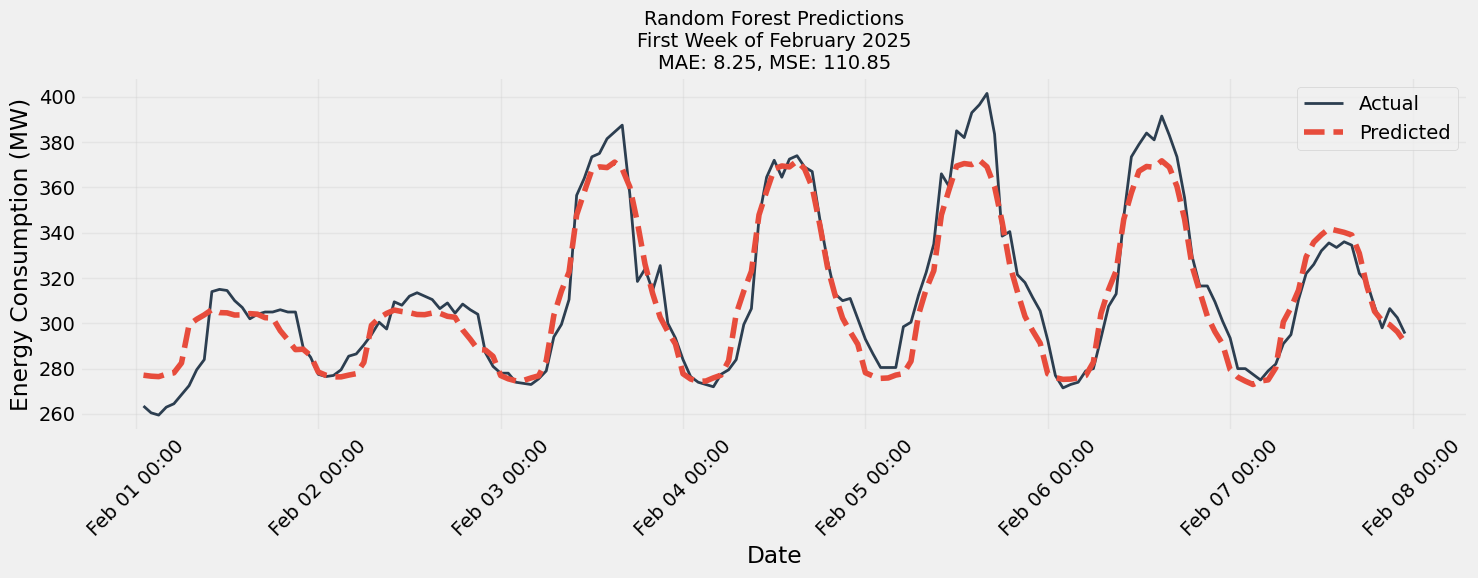

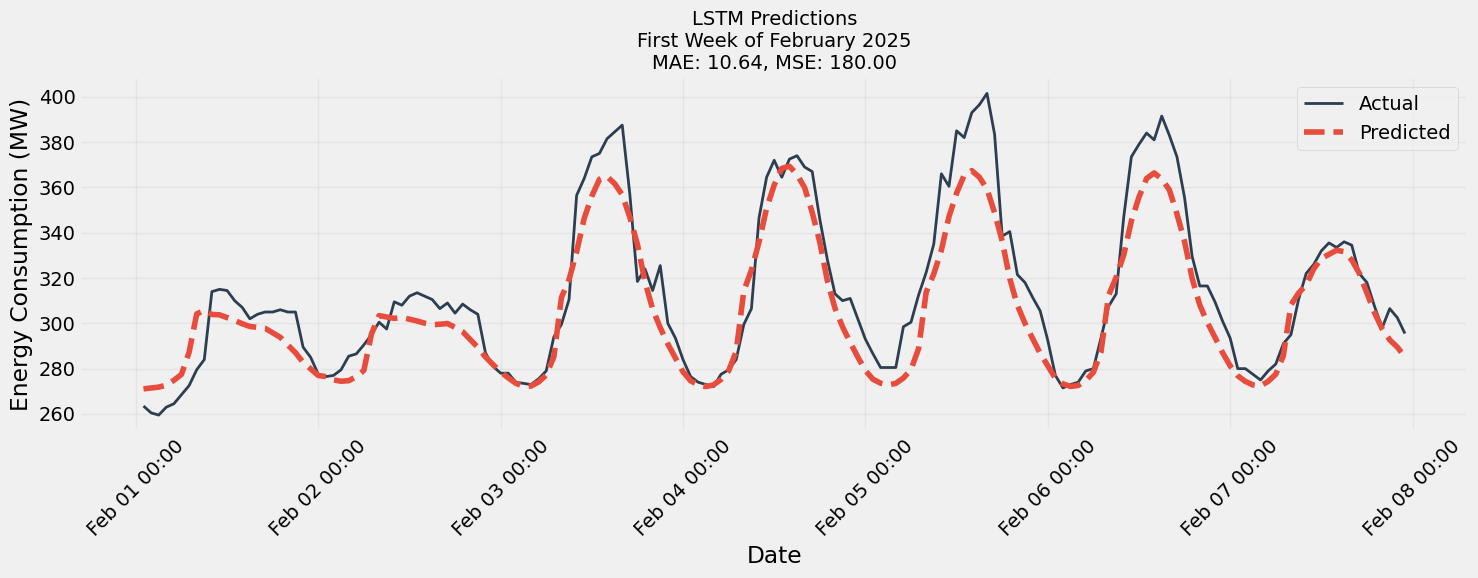

Stacking Models (First Week):
MAE: 7.33, MSE: 94.01



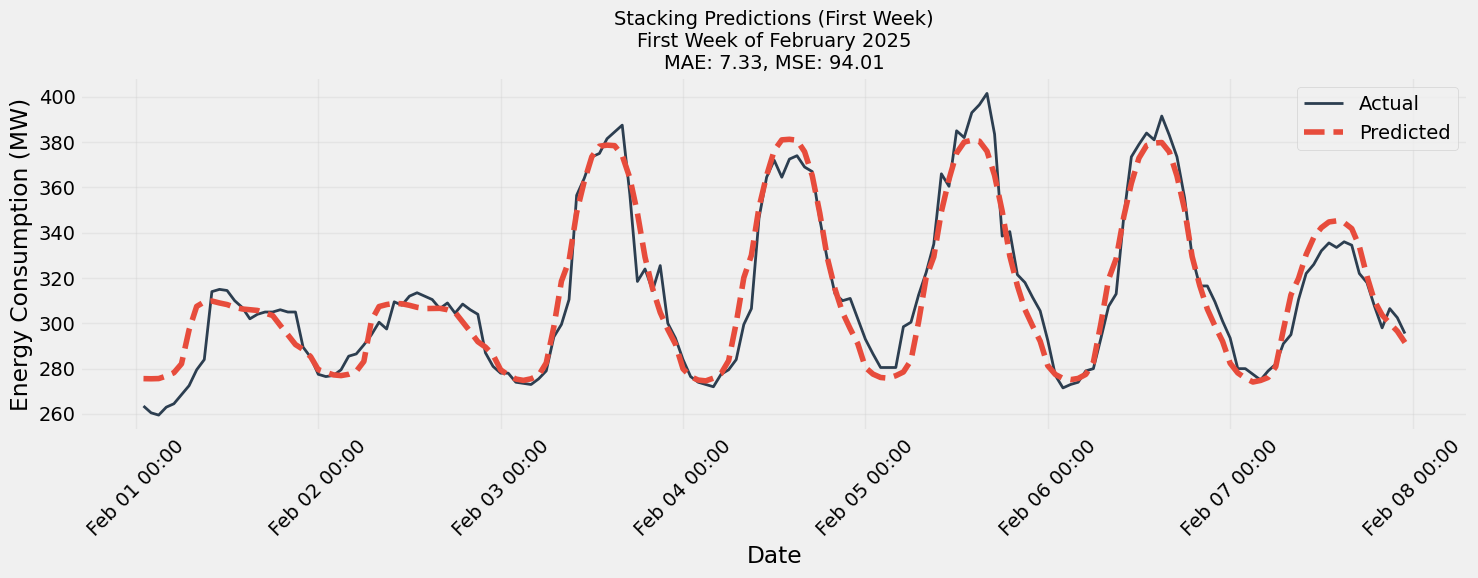


Model Weights (MSE-based):
- Random Forest: 0.619 (MSE: 110.85)
- LSTM: 0.381 (MSE: 180.00)

Weighted Average Results (First Week):
MAE: 8.79, MSE: 126.69


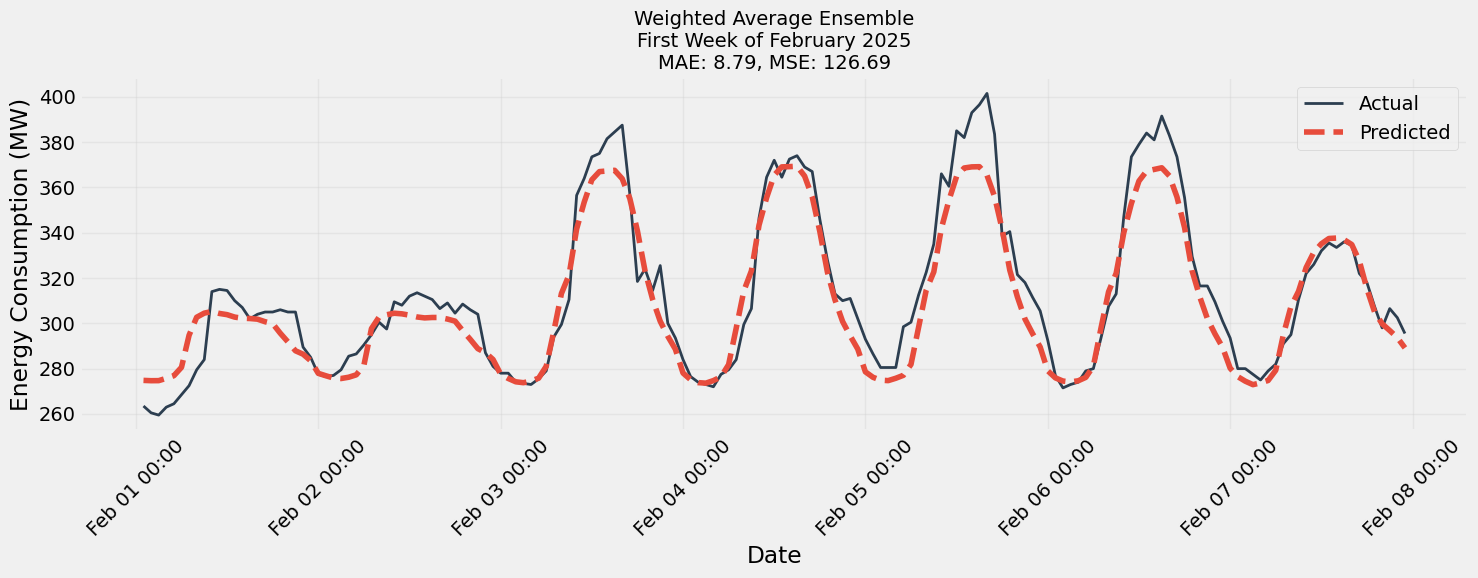


Final Forecast Includes:
- Random Forest | LSTM | Stacking | Weighted Average
Saved to February_2025_Forecast.xlsx


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# ============================================
# 1. Plot Predictions vs Actuals
# ============================================

def plot_predictions(dates, y_true, y_pred, title, mae, mse):
    plt.figure(figsize=(15, 6))
    plt.plot(dates, y_true, label='Actual', color='#2c3e50', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', linestyle='--', color='#e74c3c')
    plt.title(f'{title}\nFirst Week of February 2025\nMAE: {mae:.2f}, MSE: {mse:.2f}', fontsize=14)
    plt.ylabel('Energy Consumption (MW)')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Get first week dates and values
first_week_mask = (test_data.index >= '2025-02-01 01:00') & (test_data.index <= '2025-02-07 23:00')
first_week_dates = test_data.index[first_week_mask]
y_true_first_week = test_data.loc[first_week_mask, 'Total Consumption']

# Random Forest Predictions
rf_pred_full = search.best_estimator_.predict(X_test)
rf_pred_first_week = rf_pred_full[test_data.index.isin(first_week_dates)]

# LSTM Predictions
lstm_pred_full = scaler_target.inverse_transform(model.predict(X_test_seq)).flatten()
lstm_pred_first_week = lstm_pred_full[test_data.index[seq_length:].isin(first_week_dates)]

# Calculate MAE and MSE for RF and LSTM
mae_rf = mean_absolute_error(y_true_first_week, rf_pred_first_week)
mse_rf = mean_squared_error(y_true_first_week, rf_pred_first_week)

mae_lstm = mean_absolute_error(y_true_first_week, lstm_pred_first_week)
mse_lstm = mean_squared_error(y_true_first_week, lstm_pred_first_week)

# Plot RF and LSTM predictions
plot_predictions(first_week_dates, y_true_first_week, rf_pred_first_week, 
                 'Random Forest Predictions', mae_rf, mse_rf)
plot_predictions(first_week_dates, y_true_first_week, lstm_pred_first_week, 
                 'LSTM Predictions', mae_lstm, mse_lstm)

# ============================================
# 2. Stacking Models (First Week Only)
# ============================================

# Prepare data for stacking
X_stack = np.column_stack((rf_pred_first_week, lstm_pred_first_week))
y_stack = y_true_first_week

# Train a meta-model
meta_model = LinearRegression()
meta_model.fit(X_stack, y_stack)

# Generate stacked predictions
stacked_pred_first_week = meta_model.predict(X_stack)

# Calculate MAE and MSE for stacking
mae_stacking = mean_absolute_error(y_stack, stacked_pred_first_week)
mse_stacking = mean_squared_error(y_stack, stacked_pred_first_week)

print("Stacking Models (First Week):")
print(f"MAE: {mae_stacking:.2f}, MSE: {mse_stacking:.2f}\n")

# Plot stacking predictions
plot_predictions(first_week_dates, y_stack, stacked_pred_first_week, 
                 'Stacking Predictions (First Week)', mae_stacking, mse_stacking)


# ============================================
# 3. Weighted Average Ensemble (NEW)
# ============================================
# Calculate weights inversely proportional to MSE
total_mse = mse_rf + mse_lstm
weight_rf = mse_lstm / total_mse  # RF weight = LSTM's MSE share
weight_lstm = mse_rf / total_mse  # LSTM weight = RF's MSE share

print(f"\nModel Weights (MSE-based):")
print(f"- Random Forest: {weight_rf:.3f} (MSE: {mse_rf:.2f})")
print(f"- LSTM: {weight_lstm:.3f} (MSE: {mse_lstm:.2f})")

# Weighted average predictions (First Week)
weighted_avg_first_week = (rf_pred_first_week * weight_rf) + (lstm_pred_first_week * weight_lstm)
mae_weighted = mean_absolute_error(y_true_first_week, weighted_avg_first_week)
mse_weighted = mean_squared_error(y_true_first_week, weighted_avg_first_week)

print("\nWeighted Average Results (First Week):")
print(f"MAE: {mae_weighted:.2f}, MSE: {mse_weighted:.2f}")

# Plot weighted average
plot_predictions(first_week_dates, y_true_first_week, weighted_avg_first_week,
                 'Weighted Average Ensemble', mae_weighted, mse_weighted)

# ============================================
# 4. Full February Forecast (Updated)
# ============================================
# Align predictions for February
rf_pred_full_aligned = rf_pred_full[-len(lstm_pred_full):]  # Match lengths
X_stack_full = np.column_stack((rf_pred_full_aligned, lstm_pred_full))
stacked_pred_full = meta_model.predict(X_stack_full)
weighted_avg_full = (rf_pred_full_aligned * weight_rf) + (lstm_pred_full * weight_lstm)

# Create DataFrame with ALL methods
forecast_df = pd.DataFrame({
    'Interval End': test_data.index[-len(lstm_pred_full):],
    'Actual_Consumption': test_data['Total Consumption'].iloc[-len(lstm_pred_full):],
    'RF_Prediction': rf_pred_full_aligned.round(1),
    'LSTM_Prediction': lstm_pred_full.round(1),
    'Stacking_Prediction': stacked_pred_full.round(1),
    'Weighted_Avg_Prediction': weighted_avg_full.round(1)
})

# Filter for February and save
feb_forecast = forecast_df[(forecast_df['Interval End'] >= '2025-02-01') & 
                           (forecast_df['Interval End'] <= '2025-02-28')]
feb_forecast.to_excel('February_2025_Forecast.xlsx', index=False)

print("\nFinal Forecast Includes:")
print("- Random Forest | LSTM | Stacking | Weighted Average")
print("Saved to February_2025_Forecast.xlsx")